In [1]:
import pairtools
import os
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pandas as pd

# Define functions

In [5]:
def loadPairs(path):
    header, pairs_body = pairtools._headerops.get_header(
        pairtools._fileio.auto_open(path, 'r'))
    cols = pairtools._headerops.extract_column_names(header)
    frame = pd.read_csv(pairs_body, sep="\t", names=cols)
    return frame

def confInt(n):
    """Calculates 95% confidenc interval"""
    return (np.std(n)/(np.sqrt(len(n)))) * 1.96


# Load in files

In [6]:
pairDir1 = "/groups/gerlich/experiments/Experiments_004600/004615/Sequencing_data/Novaseq/pairs"
pairDir2 = "/groups/gerlich/experiments/Experiments_004600/004605/Sequencing_data_Novaseq/Sam"
pairDir3 = "/groups/gerlich/experiments/Experiments_004600/004638/Sequencing_data/nf-output/s4t_merged_pairsam"

# load in data rep1

BARCODES = ["GTGAAA", "GTTTCG", "CGTACG"]

sampleMapping1 = {"GTGAAA": "G2",
                  "GTTTCG": "Prometaphase",
                  "CGTACG": "ON Thymidine"}

pairsRep1 = {}

for barcode in sampleMapping1:
    pairsRep1[sampleMapping1[barcode]] = {pType:  loadPairs(os.path.join(pairDir1, f"{barcode}.{pType}.pairs.gz"))
                                          for pType in ["cis", "trans"]}

# load in data rep2

dirMapping = {"GCCAAT": pairDir2,
              "CAGATC_S8": pairDir3,
              "ACTTGA_S9": pairDir3}

sampleMapping2 = {"GCCAAT": "G2",
                  "CAGATC_S8": "Prometaphase",
                  "ACTTGA_S9": "ON Thymidine"}

pairsRep2 = {}

for barcode in sampleMapping2:
    pairsRep2[sampleMapping2[barcode]] = {pType: loadPairs(os.path.join(dirMapping[barcode], f"{barcode}.{pType}.pairs.gz"))
                                          for pType in ["cis", "trans"]}

# Merge the two replicates

In [7]:
pairs = {}
for barcode in pairsRep2.keys():
    pairs[barcode] = {}
    pairs[barcode]["cis"] = pd.concat((pairsRep1[barcode]["cis"], pairsRep2[barcode]["cis"]))
    pairs[barcode]["trans"] = pd.concat((pairsRep1[barcode]["trans"], pairsRep2[barcode]["trans"]))

# Filter based on same chromosome and valid Hi-C distance (> 10^4)

In [8]:
filt1 = {}
for barcode in pairs:
    filt1[barcode] = {pType: frame.loc[(frame["chrom1"] == frame["chrom2"]) &
                                       ((frame["pos2"] - frame["pos1"]) > 10000), :]
                      for pType, frame in pairs[barcode].items()}

# Filter based on strandedness

In [10]:
filt2 = {}

for barcode in filt1:
    filt2[barcode] = {}
    for key, value in filt1[barcode].items():
        if key == "trans":
            filt2[barcode]["trans"] = value.loc[value["strand1"] == value["strand2"], :]
        else:
            filt2[barcode]["cis"] = value.loc[value["strand1"] != value["strand2"], :]

# Calculate percentages and construct dataframe for plotting

In [11]:
perc = {}
for barcode in filt2:
    perc[barcode] = len(filt2[barcode]["trans"])/(len(filt2[barcode]["trans"]) + len(filt2[barcode]["cis"]))
finFrame = pd.DataFrame(perc, index=[0]).transpose().reset_index()
finFrame.columns = ["Condition", "values"]

# Plot result

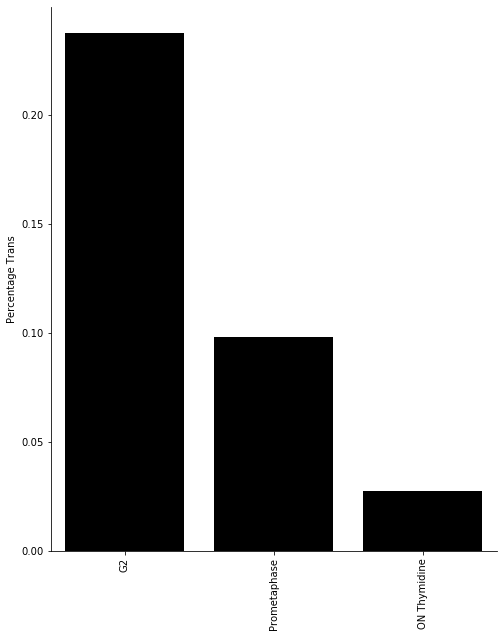

In [12]:
f, ax = plt.subplots()
sbn.barplot(x="Condition", y="values", data=finFrame, ax=ax, color="black")
ax.set_xlabel("")
ax.set_ylabel("Percentage Trans")
sbn.despine()
locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation=90)
f.set_size_inches(8, 10)
plt.show()